# COVID-19 analysis

- <https://github.com/Kamaropoulos/covid19py>

Note that the JHU data source is not providing recovery data at this time ([reference](https://github.com/ExpDev07/coronavirus-tracker-api/blob/master/README.md#recovered-cases-showing-0)).

Another source of data might be the following: <https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data>

## data sources (acquired reliably from CERN)

```Bash
virtualenv -p python3.6 COVID19
source COVID19/bin/activate
pip3.6 install pip --upgrade
pip3.6 install jupyter matplotlib numpy pandas requests seaborn
pip3.6 install COVID19Py
python3.6

import COVID19Py
import numpy as np
import pandas as pd

import json
import pickle
from uuid import uuid4

def uuid4_short():
    return str(uuid4()).split('-')[0]

def new_filename(ext='.pkl', verbose=True):
    filename = uuid4_short()+ext
    if verbose:
        print(filename)
    return filename

#covid19 = COVID19Py.COVID19(data_source='jhu')
#covid19 = COVID19Py.COVID19('https://coronavirus-tracker-api.herokuapp.com')
covid19 = COVID19Py.COVID19()
data = covid19.getAll(timelines=True)

with open(new_filename(), 'wb') as f:
    pickle.dump(covid19, f)

with open(new_filename(), 'wb') as f:
    pickle.dump(data, f)
```

In [1]:
import json
import pickle
from uuid import uuid4
import warnings

import COVID19Py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['axes.labelcolor'] = (1, 1, 1, 0)
pd.set_option("display.max_rows"   , 1000)
pd.set_option("display.max_columns", 1000)
sns.set_palette('husl')
sns.set(style='ticks')
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
plt.rcParams["figure.figsize"] = [13, 6]
sns.set()

In [3]:
def uuid4_short():
    return str(uuid4()).split('-')[0]
def new_filename(ext='.pkl', verbose=True):
    filename = uuid4_short()+ext
    if verbose: print(filename)
    return filename

In [4]:
%%time
if 0:
    covid19 = COVID19Py.COVID19(data_source='jhu') # https://github.com/CSSEGISandData/COVID-19
    with open(new_filename(), 'wb') as f:
        pickle.dump(data, f)
    data = covid19.getAll(timelines=True)
    with open(new_filename(), 'wb') as f:
        pickle.dump(data, f)

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 3.34 µs


In [5]:
if 1:
    with open('12338731.pkl', 'rb') as f:
        covid19 = pickle.load(f)
    with open('7a48429f.pkl', 'rb') as f:
        data = pickle.load(f)
    # records:
    # 2020-04-10T1904Z covid19: 12338731.pkl, data: 7a48429f.pkl
    # 2020-04-09T0544Z covid19: 7f150185.pkl, data: 5f3d2ff9.pkl
    # 2020-04-08T0616Z covid19: 8f0ec81a.pkl, data: 741cd4d4.pkl
    # 2020-04-07       covid19: f94e6997.pkl, data: 120141ce.pkl

#latest = covid19.getLatest()
#locations = covid19.getLocations(timelines=True)

df = pd.DataFrame(data['locations'])
df.head()
#df

,id,country,country_code,country_population,province,last_updated,coordinates,latest,timelines
0,0,Afghanistan,AF,29121286.0,,2020-04-10T18:31:30.295174Z,"{'latitude': '33.0', 'longitude': '65.0'}","{'confirmed': 484, 'deaths': 15, 'recovered': 0}","{'confirmed': {'latest': 484, 'timeline': {'20..."
1,1,Albania,AL,2986952.0,,2020-04-10T18:31:30.298718Z,"{'latitude': '41.1533', 'longitude': '20.1683'}","{'confirmed': 409, 'deaths': 23, 'recovered': 0}","{'confirmed': {'latest': 409, 'timeline': {'20..."
2,2,Algeria,DZ,34586184.0,,2020-04-10T18:31:30.302202Z,"{'latitude': '28.0339', 'longitude': '1.6596'}","{'confirmed': 1666, 'deaths': 235, 'recovered'...","{'confirmed': {'latest': 1666, 'timeline': {'2..."
3,3,Andorra,AD,84000.0,,2020-04-10T18:31:30.305450Z,"{'latitude': '42.5063', 'longitude': '1.5218'}","{'confirmed': 583, 'deaths': 25, 'recovered': 0}","{'confirmed': {'latest': 583, 'timeline': {'20..."
4,4,Angola,AO,13068161.0,,2020-04-10T18:31:30.308836Z,"{'latitude': '-11.2027', 'longitude': '17.8739'}","{'confirmed': 19, 'deaths': 2, 'recovered': 0}","{'confirmed': {'latest': 19, 'timeline': {'202..."


In [6]:
locations = {}

In [7]:
def process(location):
    location = location['timelines'].values[0]

    confirmed = pd.DataFrame(list(location['confirmed']['timeline'].items()), columns=['datetime', 'confirmed'])
    deaths    = pd.DataFrame(list(location['deaths']['timeline'].items()),    columns=['datetime', 'deaths'])
    recovered = pd.DataFrame(list(location['recovered']['timeline'].items()), columns=['datetime', 'recovered'])

    confirmed.index = pd.to_datetime(confirmed['datetime']); del confirmed['datetime']
    deaths.index    = pd.to_datetime(deaths['datetime'])   ; del deaths['datetime']
    recovered.index = pd.to_datetime(recovered['datetime']); del recovered['datetime']

    # merge
    location = confirmed
    location['deaths']       = deaths['deaths']
    location['recovered']    = recovered['recovered']

    # visual estimate of changes (with linear interpolation)
    half_mean_of_confirmed_cases = location['confirmed'].mean()/2
    half_mean_of_deaths_cases    = location['confirmed'].mean()/2
    location['confirmed_percentage_change']                                     = location['confirmed'].pct_change().replace(0, np.nan).interpolate(method='nearest')
    location['confirmed_percentage_change']                                     = 100*location['confirmed_percentage_change']
    location['confirmed_percentage_change_by_half_mean_confirmed_cases_factor'] = half_mean_of_confirmed_cases*location['confirmed_percentage_change']
    location['deaths_percentage_change']                                        = location['deaths'].pct_change().replace(0, np.nan).interpolate(method='nearest')
    location['deaths_percentage_change']                                        = 100*location['deaths_percentage_change']
    location['deaths_percentage_change_by_half_mean_deaths_cases_factor']       = half_mean_of_confirmed_cases*location['deaths_percentage_change']    
    
    # reindex to first confirmed case
    location = location.query('confirmed > 0').reset_index(); del location['datetime']

    display(location.tail())

    #plots
    df_plot = location.drop([
        'confirmed_percentage_change',
        'confirmed_percentage_change_by_half_mean_confirmed_cases_factor',
        'deaths_percentage_change',
        'deaths_percentage_change_by_half_mean_deaths_cases_factor'], axis=1)
    df_plot.plot(title=location_name+' confirmed cases and deaths (linear scale)')                   ; plt.xlabel('days since first confirmed case'); plt.ylabel('cases');
    df_plot.plot(title=location_name+' confirmed cases and deaths (log scale)', logy=True)           ; plt.xlabel('days since first confirmed case'); plt.ylabel('cases');

    df_plot = location[['confirmed_percentage_change', 'deaths_percentage_change']]
    df_plot.plot(title=location_name+' percentage change in cases and deaths (linear scale)')        ; plt.xlabel('days since first confirmed case'); plt.ylabel('percentage');
    df_plot.plot(title=location_name+' percentage change in cases and deaths (log scale)', logy=True); plt.xlabel('days since first confirmed case'); plt.ylabel('percentage');

    return location

# South Korea

,confirmed,deaths,recovered,confirmed_percentage_change,confirmed_percentage_change_by_half_mean_confirmed_cases_factor,deaths_percentage_change,deaths_percentage_change_by_half_mean_deaths_cases_factor
74,10237,183,NaN,0.797558,1760.796262,3.389831,7483.844669
75,10284,186,NaN,0.459119,1013.612448,1.639344,3619.236356
76,10331,192,NaN,0.457021,1008.980030,3.225806,7121.723152
77,10384,200,NaN,0.513019,1132.609732,4.166667,9198.892405
78,10423,204,NaN,0.375578,829.175972,2.000000,4415.468354


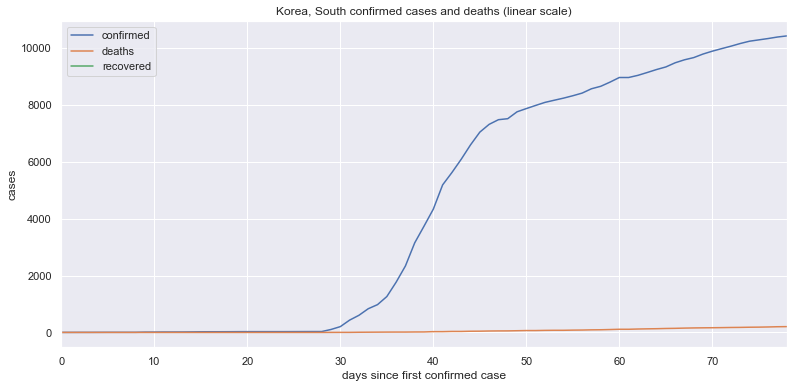

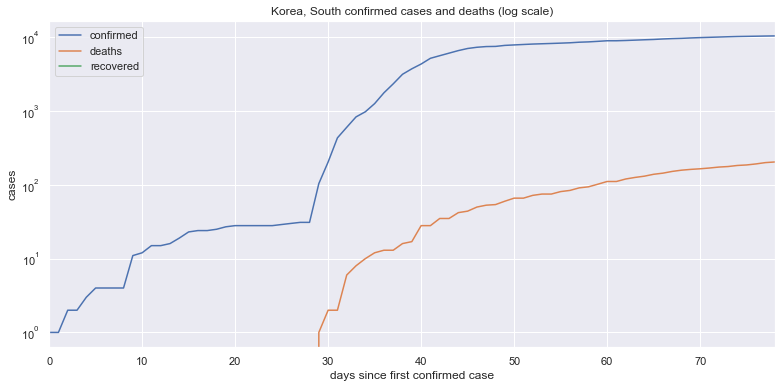

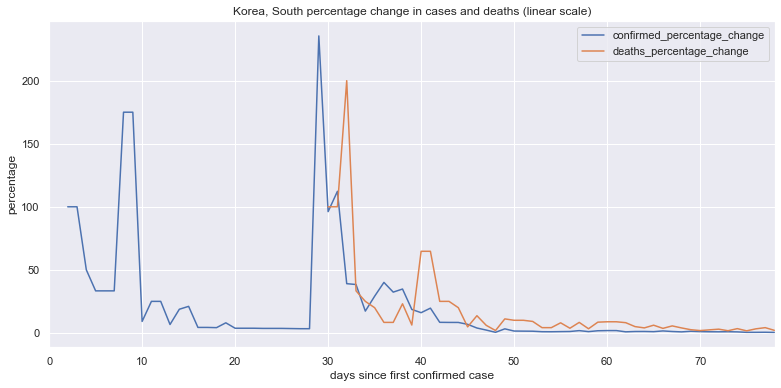

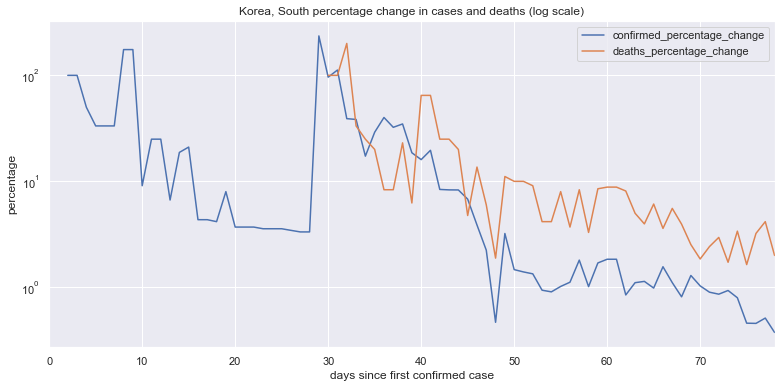

In [8]:
location_name = 'Korea, South'
location = df.query('country == @location_name')
location = process(location)
locations[location_name] = location

# Sweden

,confirmed,deaths,recovered,confirmed_percentage_change,confirmed_percentage_change_by_half_mean_confirmed_cases_factor,deaths_percentage_change,deaths_percentage_change_by_half_mean_deaths_cases_factor
65,6830,401,NaN,6.006519,4041.056529,7.506702,5050.347847
66,7206,477,NaN,5.505124,3703.729266,18.952618,12750.913855
67,7693,591,NaN,6.758257,4546.809884,23.899371,16078.982565
68,8419,687,NaN,9.437151,6349.111884,16.243655,10928.381417
69,9141,793,NaN,8.575840,5769.640852,15.429403,10380.570449


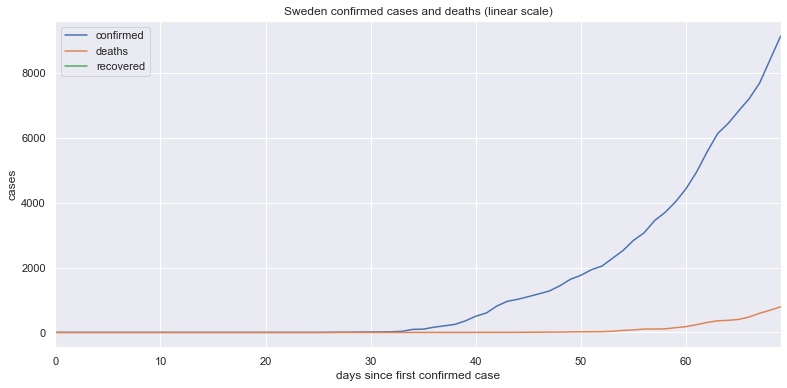

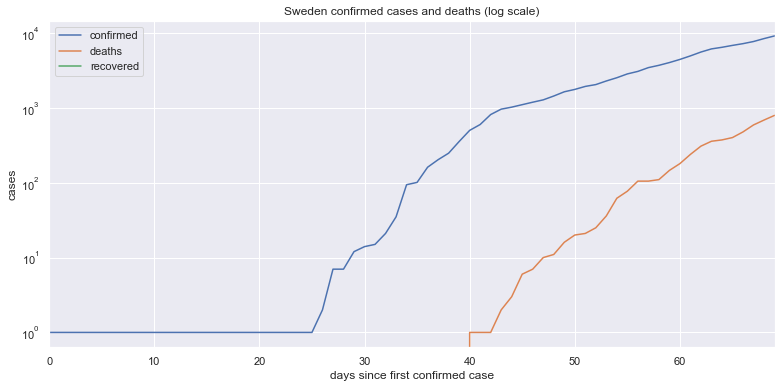

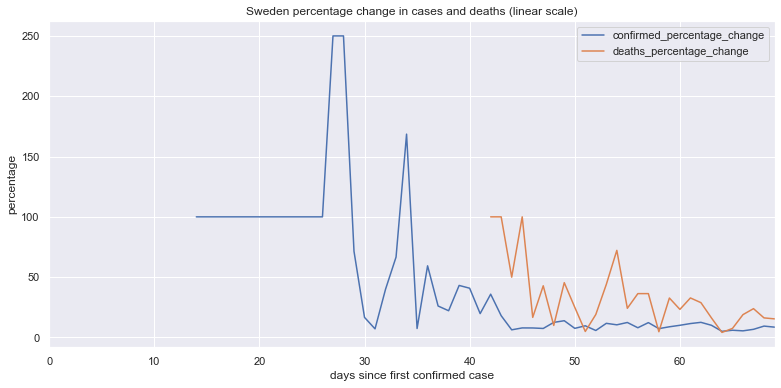

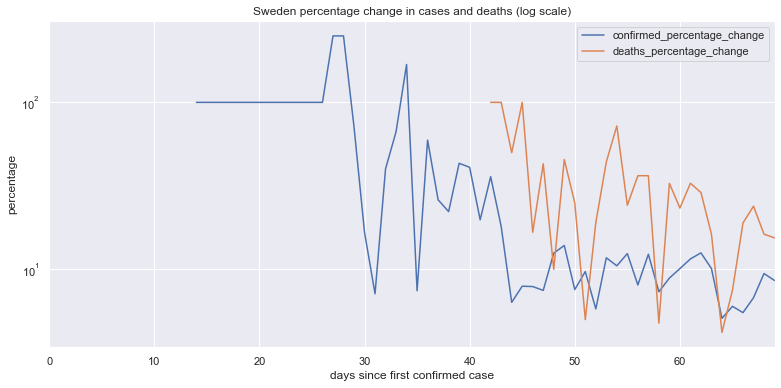

In [9]:
location_name = 'Sweden'
location = df.query('country == @location_name')
location = process(location)
locations[location_name] = location

# Ireland

,confirmed,deaths,recovered,confirmed_percentage_change,confirmed_percentage_change_by_half_mean_confirmed_cases_factor,deaths_percentage_change,deaths_percentage_change_by_half_mean_deaths_cases_factor
36,4994,158,NaN,8.470895,3656.263403,15.328467,6616.173889
37,5364,174,NaN,7.408891,3197.874158,10.126582,4370.902099
38,5709,210,NaN,6.431767,2776.121754,20.689655,8930.205151
39,6074,235,NaN,6.393414,2759.567394,11.904762,5138.411694
40,6574,263,NaN,8.231808,3553.067026,11.914894,5142.784810


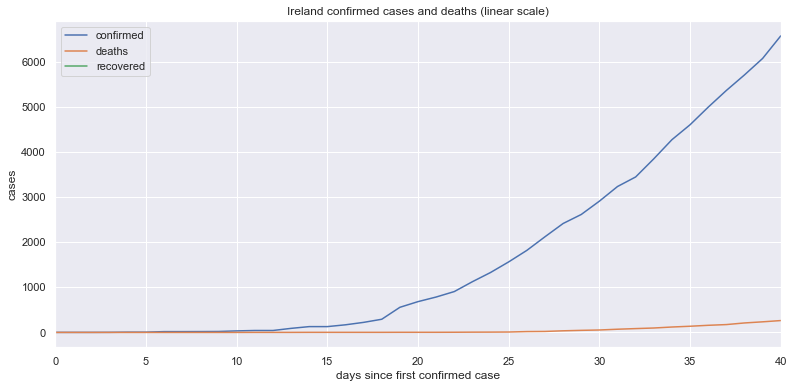

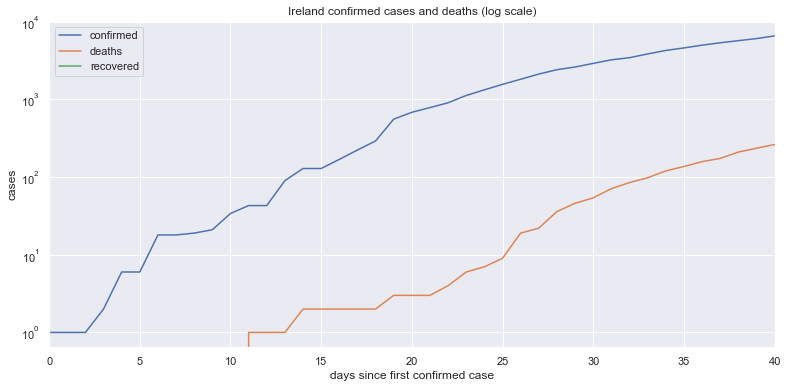

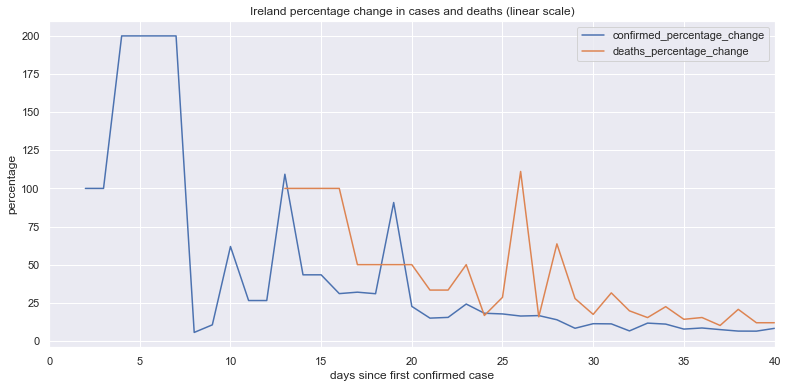

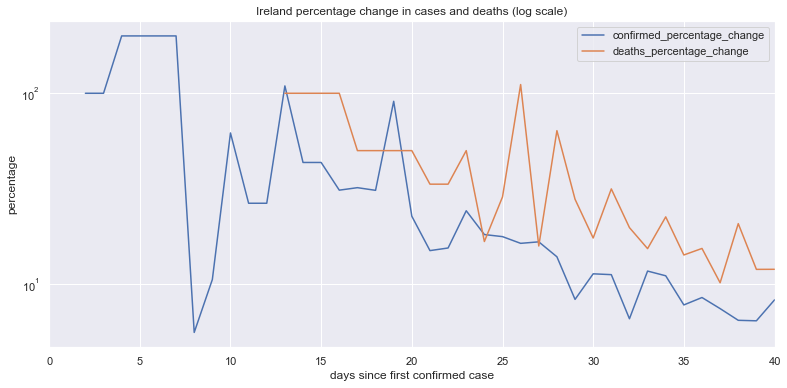

In [10]:
location_name = 'Ireland'
location = df.query('country == @location_name')
location = process(location)
locations[location_name] = location

# United Kingdom (approximate)

,confirmed,deaths,recovered,confirmed_percentage_change,confirmed_percentage_change_by_half_mean_confirmed_cases_factor,deaths_percentage_change,deaths_percentage_change_by_half_mean_deaths_cases_factor
65,47806,4934,NaN,14.087297,52380.314421,14.398331,53536.820680
66,51608,5373,NaN,7.952977,29571.281133,8.897446,33083.070454
67,55242,6159,NaN,7.041544,26182.332197,14.628699,54393.391712
68,60733,7097,NaN,9.939901,36959.193427,15.229745,56628.240652
69,65077,7978,NaN,7.152619,26595.338176,12.413696,46157.421303


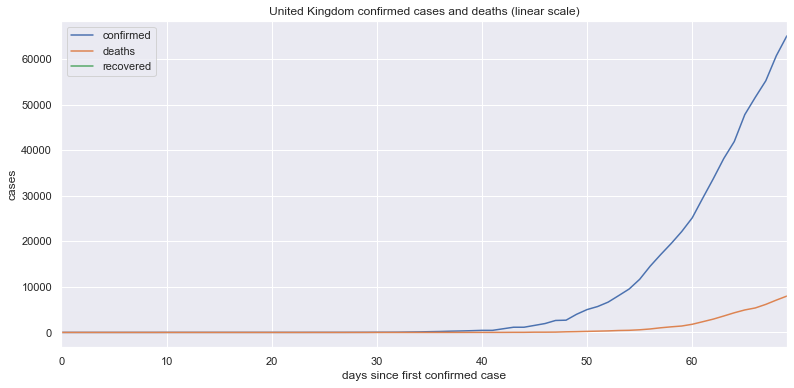

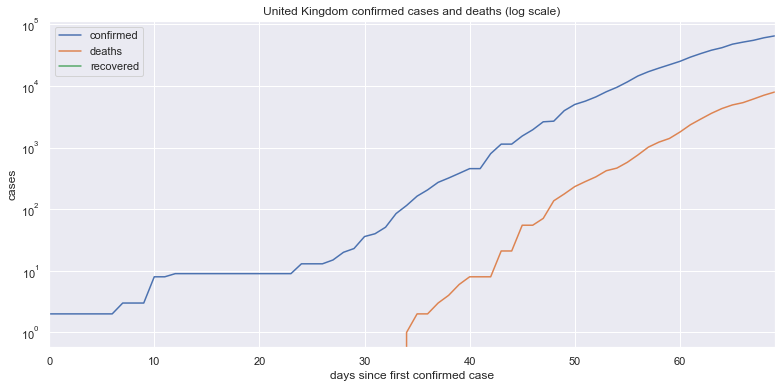

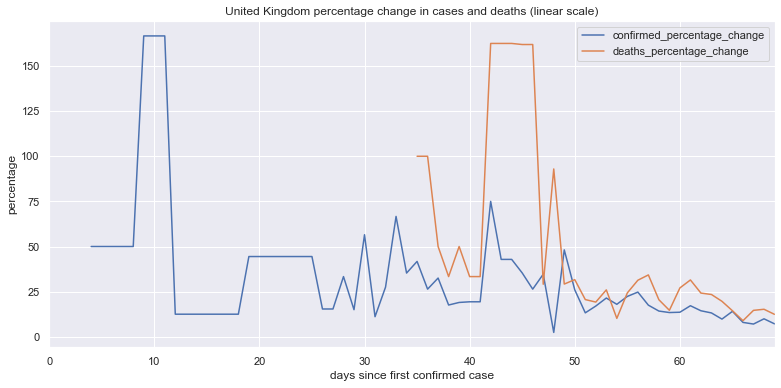

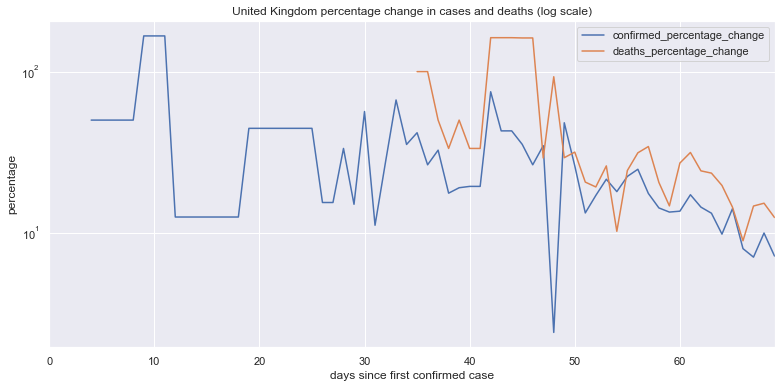

In [11]:
location_name = 'United Kingdom'
#location = df.query('country == @location_name')
location = df.query('country in ["United Kingdom"] and province == ""')
location = process(location)
locations[location_name] = location

# Germany

,confirmed,deaths,recovered,confirmed_percentage_change,confirmed_percentage_change_by_half_mean_confirmed_cases_factor,deaths_percentage_change,deaths_percentage_change_by_half_mean_deaths_cases_factor
69,100123,1584,NaN,4.194938,39329.191592,9.695291,90897.156282
70,103374,1810,NaN,3.247006,30441.957102,14.267677,133765.068406
71,107663,2016,NaN,4.149012,38898.618633,11.381215,106703.361074
72,113296,2349,NaN,5.232067,49052.678653,16.517857,154861.392405
73,118181,2607,NaN,4.311714,40424.014880,10.983397,102973.658600


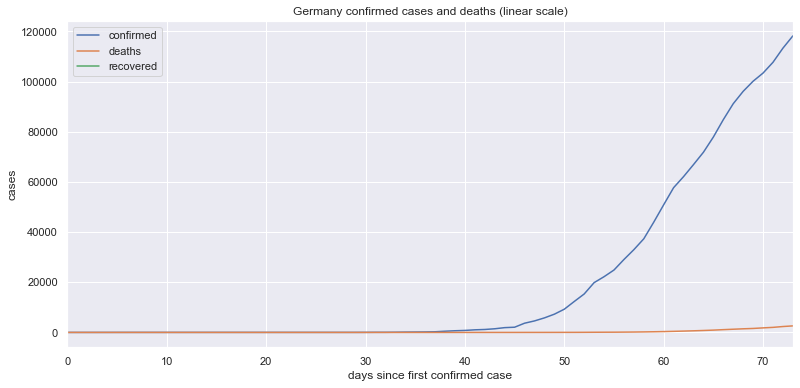

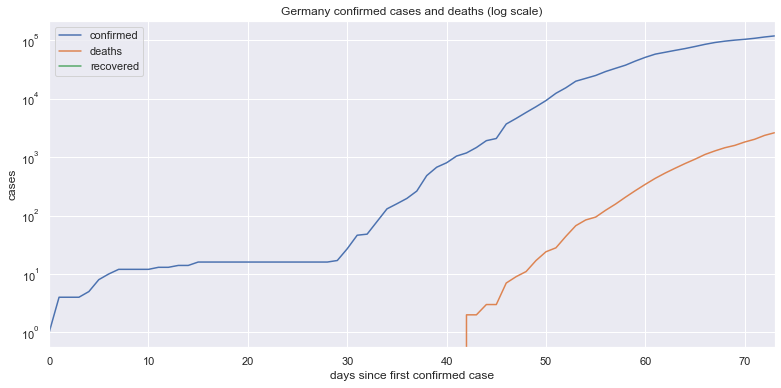

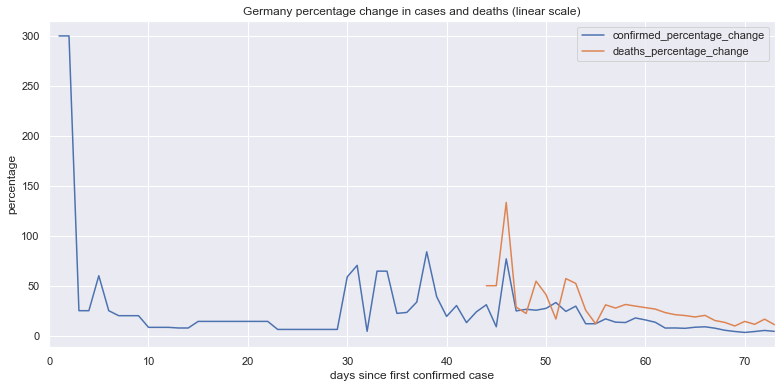

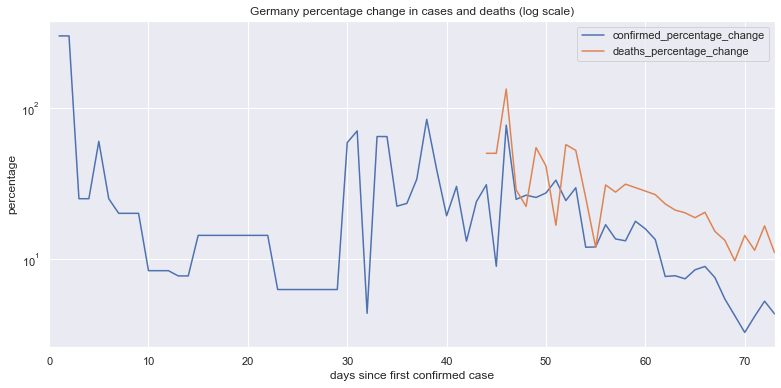

In [12]:
location_name = 'Germany'
location = df.query('country == @location_name')
location = process(location)
locations[location_name] = location

# Italy

,confirmed,deaths,recovered,confirmed_percentage_change,confirmed_percentage_change_by_half_mean_confirmed_cases_factor,deaths_percentage_change,deaths_percentage_change_by_half_mean_deaths_cases_factor
65,128948,15887,NaN,3.462995,51758.472071,3.417524,51078.850863
66,132547,16523,NaN,2.791048,41715.438364,4.003273,59833.553427
67,135586,17127,NaN,2.292772,34268.127422,3.655511,54635.838344
68,139422,17669,NaN,2.829201,42285.680647,3.164594,47298.521396
69,143626,18279,NaN,3.015306,45067.241318,3.452374,51599.731275


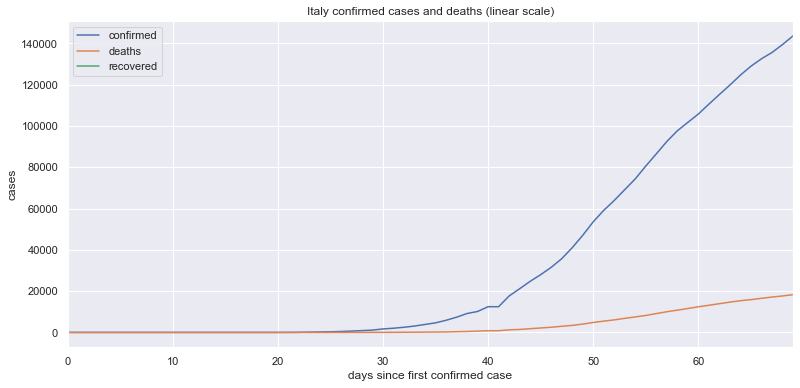

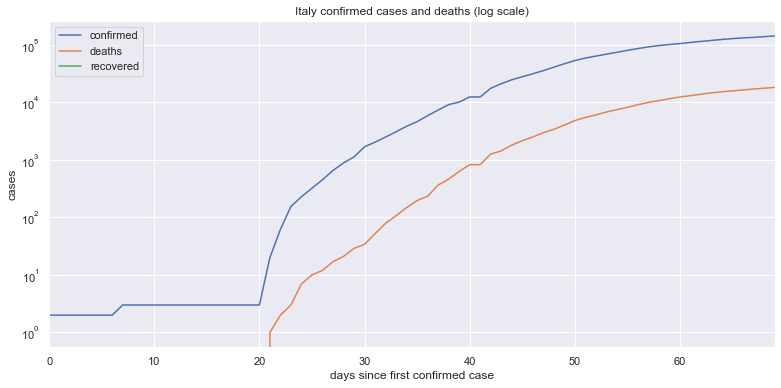

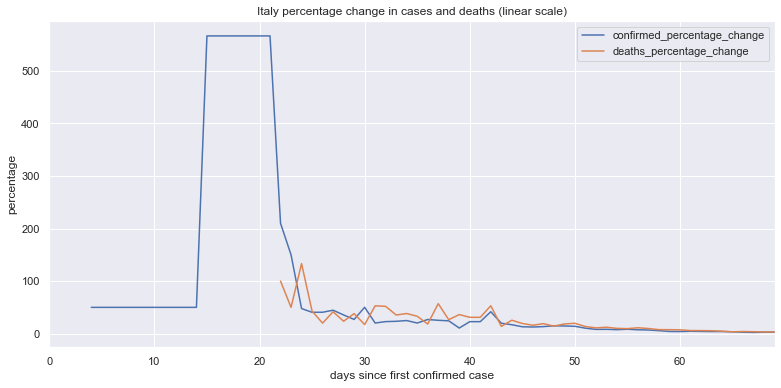

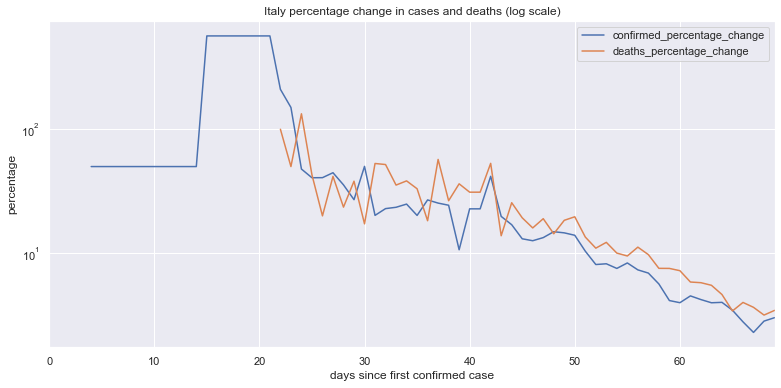

In [13]:
location_name = 'Italy'
location = df.query('country == @location_name')
location = process(location)
locations[location_name] = location

# United States of America

,confirmed,deaths,recovered,confirmed_percentage_change,confirmed_percentage_change_by_half_mean_confirmed_cases_factor,deaths_percentage_change,deaths_percentage_change_by_half_mean_deaths_cases_factor
74,337072,9619,NaN,9.136709,238212.509642,14.416558,375868.855520
75,366667,10783,NaN,8.780023,228912.988691,12.101050,315498.882091
76,396223,12722,NaN,8.060720,210159.294470,17.982009,468827.386521
77,429052,14695,NaN,8.285486,216019.392896,15.508568,404339.773223
78,461437,16478,NaN,7.548036,196792.589214,12.133379,316341.756647


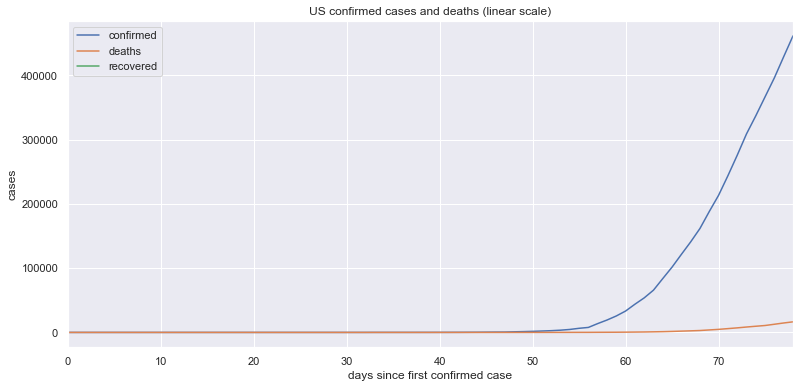

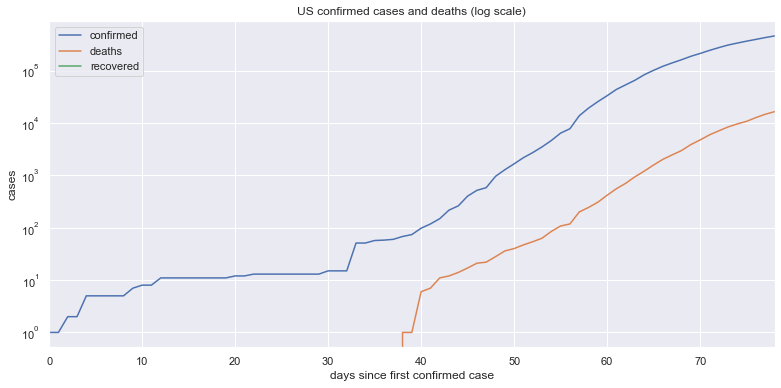

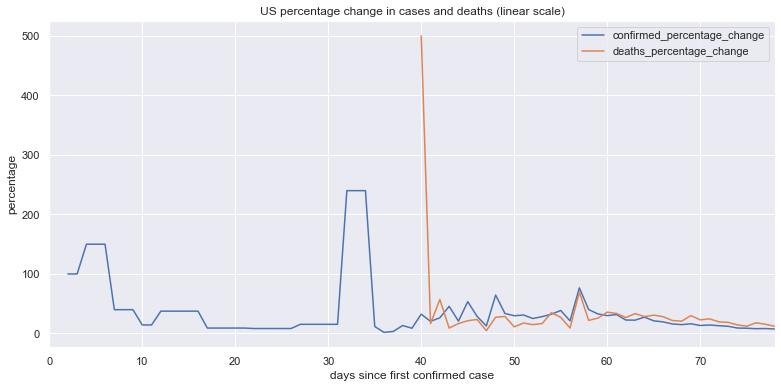

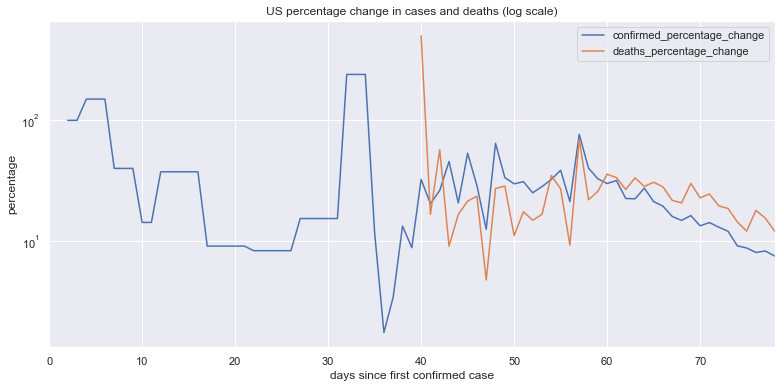

In [14]:
location_name = 'US'
location = df.query('country == @location_name')
location = process(location)
locations[location_name] = location

---

In [15]:
South_Korea              = locations['Korea, South']
Sweden                   = locations['Sweden']
Ireland                  = locations['Ireland']
United_Kingdom           = locations['United Kingdom']
Germany                  = locations['Germany']
Italy                    = locations['Italy']
United_States_of_America = locations['US']

locations_list           = [South_Korea,
                            Sweden,
                            Ireland,
                            United_Kingdom,
                            Germany,
                            Italy,
                            United_States_of_America]

In [16]:
#South_Korea

In [17]:
_df = pd.merge(South_Korea.add_suffix('_South_Korea'), Sweden.add_suffix('_Sweden'), how='inner', left_index=True, right_index=True)
_df = pd.merge(_df, Ireland.add_suffix('_Ireland'), how='inner', left_index=True, right_index=True)
_df = pd.merge(_df, United_Kingdom.add_suffix('_United_Kingdom'), how='inner', left_index=True, right_index=True)
_df = pd.merge(_df, Germany.add_suffix('_Germany'), how='inner', left_index=True, right_index=True)
_df = pd.merge(_df, Italy.add_suffix('_Italy'), how='inner', left_index=True, right_index=True)
_df = pd.merge(_df, United_States_of_America.add_suffix('_United_States_of_America'), how='inner', left_index=True, right_index=True)
_df.tail()

,confirmed_South_Korea,deaths_South_Korea,recovered_South_Korea,confirmed_percentage_change_South_Korea,confirmed_percentage_change_by_half_mean_confirmed_cases_factor_South_Korea,deaths_percentage_change_South_Korea,deaths_percentage_change_by_half_mean_deaths_cases_factor_South_Korea,confirmed_Sweden,deaths_Sweden,recovered_Sweden,confirmed_percentage_change_Sweden,confirmed_percentage_change_by_half_mean_confirmed_cases_factor_Sweden,deaths_percentage_change_Sweden,deaths_percentage_change_by_half_mean_deaths_cases_factor_Sweden,confirmed_Ireland,deaths_Ireland,recovered_Ireland,confirmed_percentage_change_Ireland,confirmed_percentage_change_by_half_mean_confirmed_cases_factor_Ireland,deaths_percentage_change_Ireland,deaths_percentage_change_by_half_mean_deaths_cases_factor_Ireland,confirmed_United_Kingdom,deaths_United_Kingdom,recovered_United_Kingdom,confirmed_percentage_change_United_Kingdom,confirmed_percentage_change_by_half_mean_confirmed_cases_factor_United_Kingdom,deaths_percentage_change_United_Kingdom,deaths_percentage_change_by_half_mean_deaths_cases_factor_United_Kingdom,confirmed_Germany,deaths_Germany,recovered_Germany,confirmed_percentage_change_Germany,confirmed_percentage_change_by_half_mean_confirmed_cases_factor_Germany,deaths_percentage_change_Germany,deaths_percentage_change_by_half_mean_deaths_cases_factor_Germany,confirmed_Italy,deaths_Italy,recovered_Italy,confirmed_percentage_change_Italy,confirmed_percentage_change_by_half_mean_confirmed_cases_factor_Italy,deaths_percentage_change_Italy,deaths_percentage_change_by_half_mean_deaths_cases_factor_Italy,confirmed_United_States_of_America,deaths_United_States_of_America,recovered_United_States_of_America,confirmed_percentage_change_United_States_of_America,confirmed_percentage_change_by_half_mean_confirmed_cases_factor_United_States_of_America,deaths_percentage_change_United_States_of_America,deaths_percentage_change_by_half_mean_deaths_cases_factor_United_States_of_America
36,1766,13,NaN,40.047581,88414.413917,8.333333,18397.784810,161,0,NaN,59.405941,39967.038476,NaN,NaN,4994,158,NaN,8.470895,3656.263403,15.328467,6616.173889,206,2,NaN,26.380368,98089.221092,100.000000,371826.582278,196,0,NaN,23.270440,218169.508797,NaN,NaN,5883,233,NaN,26.898188,402024.575283,18.274112,273127.764570,58,0,NaN,1.754386,45740.395292,NaN,NaN
37,2337,13,NaN,32.332956,71382.571642,8.333333,18397.784810,203,0,NaN,26.086957,17550.742983,NaN,NaN,5364,174,NaN,7.408891,3197.874158,10.126582,4370.902099,273,3,NaN,32.524272,120933.888411,50.000000,185913.291139,262,0,NaN,33.673469,315701.989150,NaN,NaN,7375,366,NaN,25.361210,379052.661498,57.081545,853149.804422,60,0,NaN,3.448276,89903.535574,NaN,NaN
38,3150,16,NaN,34.788190,76803.075998,23.076923,50947.711782,248,0,NaN,22.167488,14913.808692,NaN,NaN,5709,210,NaN,6.431767,2776.121754,20.689655,8930.205151,321,4,NaN,17.582418,65376.102379,33.333333,123942.194093,482,0,NaN,83.969466,787246.690501,NaN,NaN,9172,463,NaN,24.366102,364179.611328,26.502732,396114.029536,68,1,NaN,13.333333,347627.004219,inf,inf
39,3736,17,NaN,18.603175,41070.864376,6.250000,13798.338608,355,0,NaN,43.145161,29027.136076,NaN,NaN,6074,235,NaN,6.393414,2759.567394,11.904762,5138.411694,382,6,NaN,19.003115,70658.634016,50.000000,185913.291139,670,0,NaN,39.004149,365679.205841,NaN,NaN,10149,631,NaN,10.651984,159206.242789,36.285097,542322.803948,74,1,NaN,8.823529,230047.282204,inf,inf
40,4335,28,NaN,16.033191,35397.022809,64.705882,142853.387937,500,1,NaN,40.845070,27479.684436,inf,inf,6574,263,NaN,8.231808,3553.067026,11.914894,5142.784810,456,8,NaN,19.371728,72029.233216,33.333333,123942.194093,799,0,NaN,19.253731,180511.286605,NaN,NaN,12462,827,NaN,22.790423,340629.263780,31.061807,464254.677125,98,6,NaN,32.432432,845579.199453,500.0,1.303601e+07


# comparisons: confirmed cases

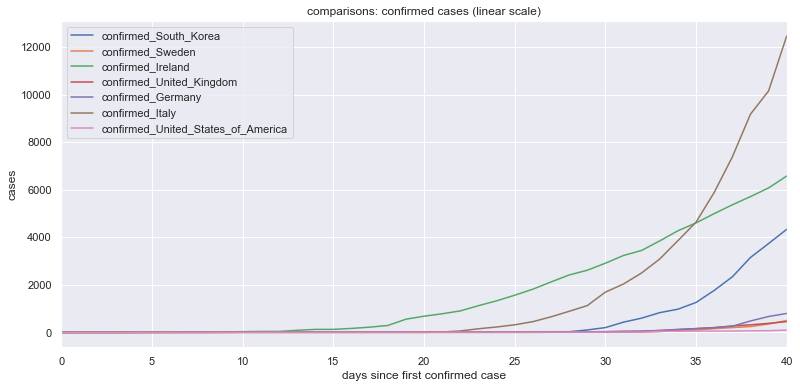

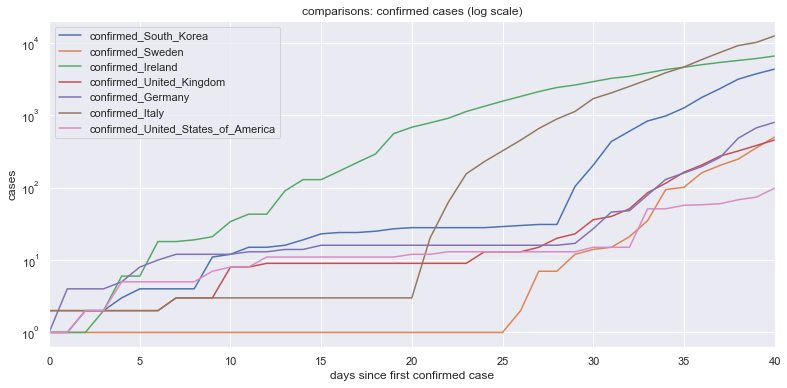

In [18]:
__df = _df[[
    'confirmed_South_Korea',
    'confirmed_Sweden',
    'confirmed_Ireland',
    'confirmed_United_Kingdom',
    'confirmed_Germany',
    'confirmed_Italy',
    'confirmed_United_States_of_America']]

title = 'comparisons: confirmed cases'
__df.plot(title=title+' '+'(linear scale)')        ; plt.xlabel('days since first confirmed case'); plt.ylabel('cases');
__df.plot(title=title+' '+'(log scale)', logy=True); plt.xlabel('days since first confirmed case'); plt.ylabel('cases');

# comparisons: deaths

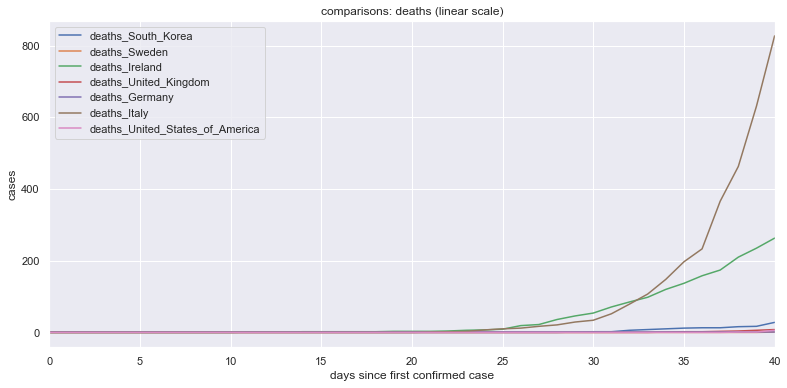

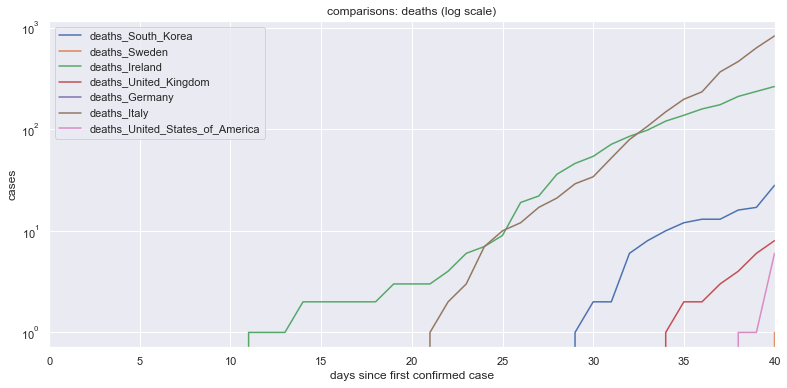

In [19]:
__df = _df[[
    'deaths_South_Korea',
    'deaths_Sweden',
    'deaths_Ireland',
    'deaths_United_Kingdom',
    'deaths_Germany',
    'deaths_Italy',
    'deaths_United_States_of_America']]
__df.tail()

title = 'comparisons: deaths'
__df.plot(title=title+' '+'(linear scale)')        ; plt.xlabel('days since first confirmed case'); plt.ylabel('cases');
__df.plot(title=title+' '+'(log scale)', logy=True); plt.xlabel('days since first confirmed case'); plt.ylabel('cases');

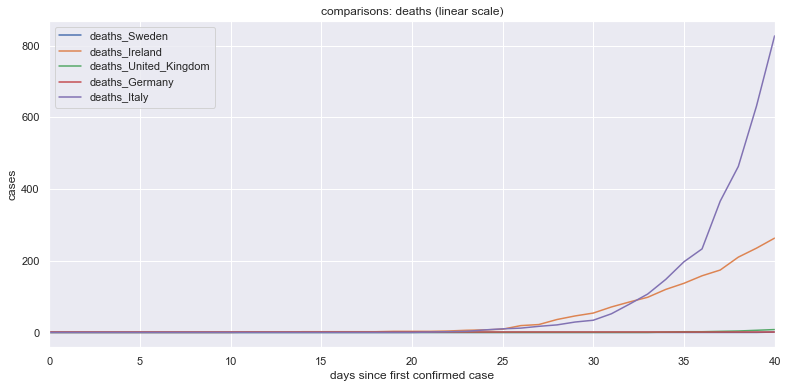

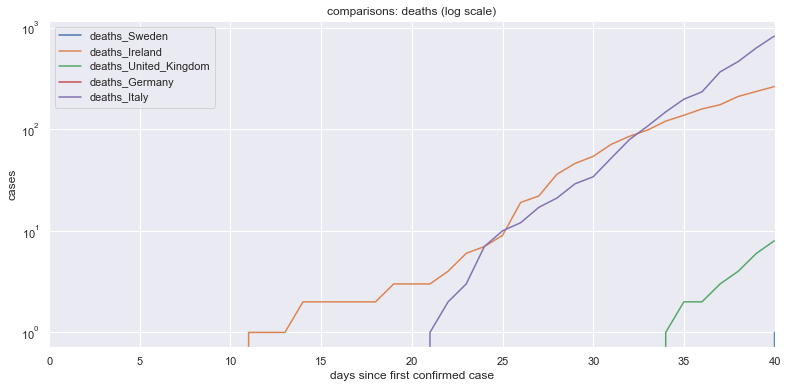

In [20]:
# some EU countries
__df = _df[[
    'deaths_Sweden',
    'deaths_Ireland',
    'deaths_United_Kingdom',
    'deaths_Germany',
    'deaths_Italy']]
__df.tail()

title = 'comparisons: deaths'
__df.plot(title=title+' '+'(linear scale)')        ; plt.xlabel('days since first confirmed case'); plt.ylabel('cases');
__df.plot(title=title+' '+'(log scale)', logy=True); plt.xlabel('days since first confirmed case'); plt.ylabel('cases');

# comparisons: changes in confirmed cases

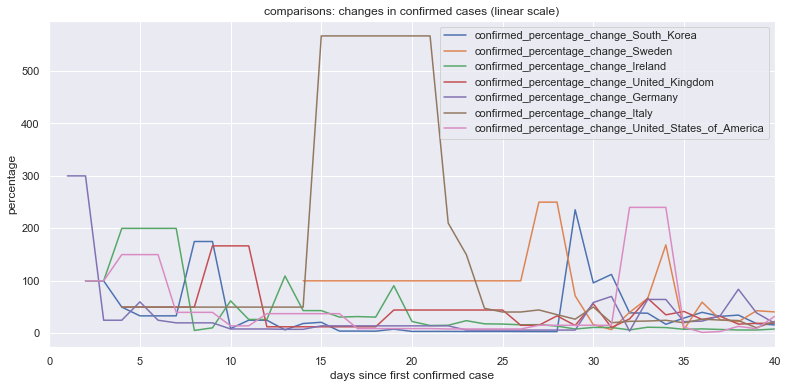

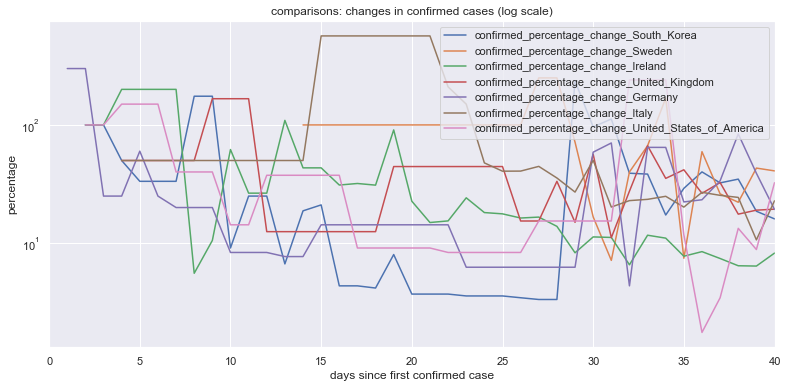

In [21]:
__df = _df[[
    'confirmed_percentage_change_South_Korea',
    'confirmed_percentage_change_Sweden',
    'confirmed_percentage_change_Ireland',
    'confirmed_percentage_change_United_Kingdom',
    'confirmed_percentage_change_Germany',
    'confirmed_percentage_change_Italy',
    'confirmed_percentage_change_United_States_of_America']]
__df.tail()

title = 'comparisons: changes in confirmed cases'
__df.plot(title=title+' '+'(linear scale)')        ; plt.xlabel('days since first confirmed case'); plt.ylabel('percentage');
__df.plot(title=title+' '+'(log scale)', logy=True); plt.xlabel('days since first confirmed case'); plt.ylabel('percentage');

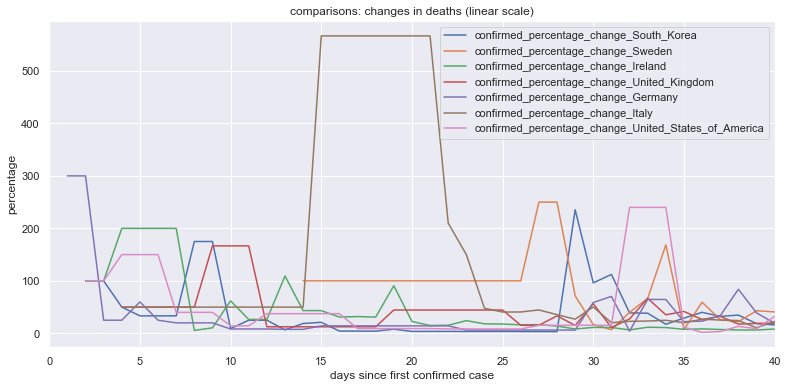

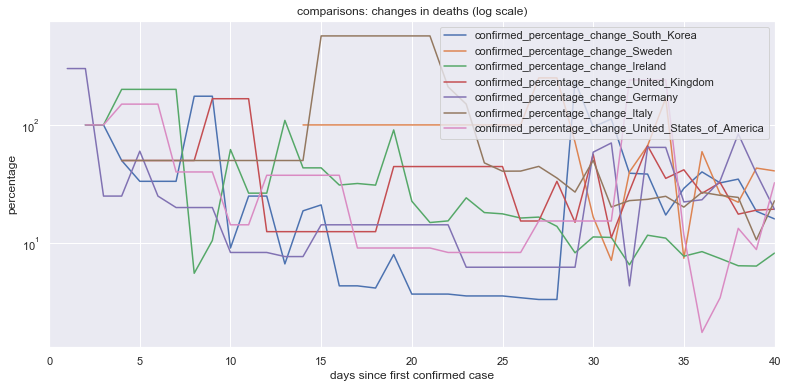

In [22]:
___df = _df[[
    'deaths_percentage_change_South_Korea',
    'deaths_percentage_change_Sweden',
    'deaths_percentage_change_Ireland',
    'deaths_percentage_change_United_Kingdom',
    'deaths_percentage_change_Germany',
    'deaths_percentage_change_Italy',
    'deaths_percentage_change_United_States_of_America']]
___df.tail()

title = 'comparisons: changes in deaths'
__df.plot(title=title+' '+'(linear scale)')        ; plt.xlabel('days since first confirmed case'); plt.ylabel('percentage');
__df.plot(title=title+' '+'(log scale)', logy=True); plt.xlabel('days since first confirmed case'); plt.ylabel('percentage');

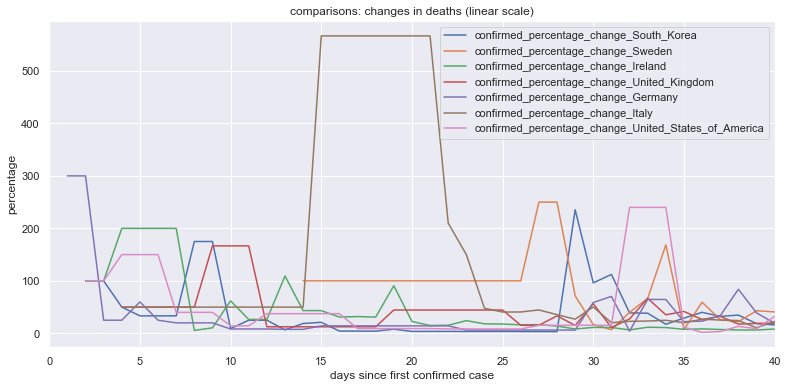

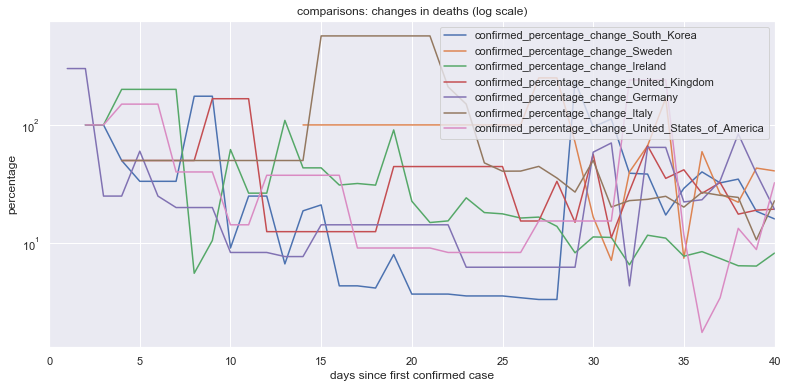

In [23]:
# some EU countries
___df = _df[[
    'deaths_percentage_change_Sweden',
    'deaths_percentage_change_Ireland',
    'deaths_percentage_change_United_Kingdom',
    'deaths_percentage_change_Germany',
    'deaths_percentage_change_Italy']]
___df.tail()

title = 'comparisons: changes in deaths'
__df.plot(title=title+' '+'(linear scale)')        ; plt.xlabel('days since first confirmed case'); plt.ylabel('percentage');
__df.plot(title=title+' '+'(log scale)', logy=True); plt.xlabel('days since first confirmed case'); plt.ylabel('percentage');